In [1]:
import sys
import os
sys.path.append(os.path.abspath('../..')) # include top level package in python path

In [2]:
import torch
from comparison.examples.vae_mnist import VAE_MNIST
from comparison.loss import ELBO, IWAE_loss, CIWAE_loss, PIWAE_loss
from comparison.metric import IWAE_64, log_px
from comparison.metric import IWAE_metric, CIWAE_metric, PIWAE_metric, sample_ess
from tqdm.notebook import tqdm
import csv

In [3]:
# Change device as needed. 
# CPU is supported on all machines, CUDA for specific GPUs.

# device = 'cpu'
device = 'cuda'

import time
model_dir = './_modeldata/'
idstr = "bernoulli"
print(idstr)

bernoulli


In [4]:
import re
import pandas as pd

class MNISTTrainData():
    def __init__(self, model_dir, idstr):
        self.model_dir = model_dir
        self.idstr = idstr
        
    def model_from_filename(self, filename):
        model_str = "^%s-(.+)-r([0-9]+)-([^-]+)-model\\.pt" % self.idstr
        match = re.search(model_str, filename)
        if match == None:
            return None
        loss = match.group(1)
        run_no = int(match.group(2))
        epoch = self.epoch_from_str(match.group(3))

        return (loss, run_no, epoch)
    
    def results_from_filename(self, filename):
        results_str = "^%s-(.+)-r([0-9]+)-results\\.csv" % self.idstr
        match = re.search(results_str, filename)
        if match == None:
            return None
        loss = match.group(1)
        run_no = int(match.group(2))

        return (loss, run_no)
        
    def get_files(self):
        filenames = os.listdir(self.model_dir)
        models = [self.model_from_filename(fl) for fl in filenames]
        results = [self.results_from_filename(fl) for fl in filenames]
        return [*filter(lambda x: x, models)], [*filter(lambda x: x, results)]
        
    def load_all_results(self):
        results = {
            'vae': [],
            'iwae': [],
            'ciwae-05': [],
            'miwae-8-8': [],
            'piwae-8-8': [],
        }
        
        _, result_files = self.get_files()
        for loss, run_no in result_files:
            data = self.load_results(loss, run_no)
            results[loss].append((run_no, data))
            
        return results
        
    def epoch_str(self, epoch = None):
        return "final" if epoch == None else "e" + str(epoch)
    
    def epoch_from_str(self, s):
        if s == "final":
            return None
        else:
            match = re.search("e([0-9]+)", s)
            if not match:
                raise ValueError
            return int(match.group(1))
            
    def start_prefix(self):
        return self.model_dir + self.idstr + "-start"
    
    def run_prefix(self, loss, run_no):
        return (
            self.model_dir 
            + self.idstr 
            + "-"
            + loss 
            + "-r"
            + str(run_no)
        )
        
    def start_model_str(self):
        return self.start_prefix() + "-model.pt"
        
    def model_str(self, epoch, *args, **kargs):
        return self.run_prefix(*args, **kargs) + "-" + self.epoch_str(epoch)  + "-model.pt"

    def results_str(self, *args, **kargs):
        return self.run_prefix(*args, **kargs) + "-results.csv"
        
    def load_start(self, model):
        return model.load_state_dict(torch.load(self.start_model_str()))
    
    def save_start(self, model):
        torch.save(model.state_dict(), self.start_model_str())
        
    def load_model(self, model, loss, run_no, epoch):
        filename = self.model_str(epoch, loss, run_no)
        return model.load_state_dict(torch.load(filename))
        
    def save_model(self, model, loss, run_no, epoch):
        filename = self.model_str(epoch, loss, run_no)
        torch.save(model.state_dict(), filename)
        
    def load_results(self, loss, run_no):
        filename = self.results_str(loss, run_no)
        return pd.read_csv(filename)
        
    def save_results(self, test_metrics, loss, run_no):
        filename = self.results_str(loss, run_no)
        test_metrics.to_csv(filename)
            
mnist_train_data = MNISTTrainData(model_dir, idstr)

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

train_dataset = datasets.MNIST('./_mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       torch.bernoulli
                       
                   ]))

test_dataset = datasets.MNIST('./_mnist', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       torch.bernoulli
                   ]))


def static_copy(dataset):
    ys = torch.tensor([*map(lambda tpl: tpl[1], dataset)])
    xs = torch.cat([*map(lambda tpl: tpl[0].unsqueeze(0), dataset)], dim=0)
    return TensorDataset(xs, ys)

#train_dataset = static_copy(train_dataset)
#test_datast = static_copy(test_dataset)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# We set a low batch_size for sampling IWAE with K=5000
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)


In [6]:
def train_epoch(model, optims, dataloader, loss_function, label):
    model.train()
    for imgs, _ in tqdm(dataloader, desc="Training Epoch №%s" % label, leave=False):
        imgs = imgs.view(-1, 28*28).to(device)
        losses = loss_function(model, imgs)
        
        if type(losses) is not tuple:
            optim = optims[0]
            loss = -losses
            optim.zero_grad()
            loss.backward()
            optim.step()
        else: #PIWAE
            grads = []
            for idx, (optim, loss) in enumerate(zip(optims, losses)):
                loss = -loss
                for p in model.parameters():
                    p.grad = None
                loss.backward(retain_graph=idx<len(optims)-1)
                grads.append([p.grad for p in optim.param_groups[0]["params"]])

            for idx, optim in enumerate(optims):
                for g, p in zip(grads[idx], optim.param_groups[0]["params"]):
                    #assert(idx == 1 or not torch.equal(p.grad, g))
                    p.grad = g
            
            for optim in optims:
                optim.step()



In [7]:
def test_epoch(model, test_loader, label):
    with torch.no_grad():
        #evaluate metrics
        test_scores = {
            "iwae-64": 0.0,
            "logpx": 0.0,
            "-kl"    : 0.0
        }

        for imgs, _ in tqdm(test_loader, desc="Test Epoch №%s" % label, leave=False):
            imgs = imgs.view(-1, 28*28).to(device)            
            IWAE_64_loss = IWAE_64(model, imgs)
            logpx_loss = log_px(model, imgs)
            negKL_loss = logpx_loss - IWAE_64_loss
            
            test_scores["iwae-64"] += IWAE_64_loss.sum().item()
            test_scores["logpx"] += logpx_loss.sum().item()
            test_scores["-kl"] += negKL_loss.sum().item()
        
        N = len(test_loader.dataset)
        test_scores["iwae-64"] /= N
        test_scores["logpx"] /= N
        test_scores["-kl"] /= N
        
        return test_scores
        

In [8]:
def train_and_evaluate(
    model, 
    train_loader, 
    test_loader, 
    test,
    run_no
):    
    test_metrics = {
        "epoch"  : [],
        "iwae-64": [],
        "logpx": [],
        "-kl"    : []
    }

    for epoch in range(1, test.no_epochs + 1):
        train_epoch(model, test.optims, train_loader, test.loss_fn, epoch)
        
        # save metrics
        if epoch % test.epochs_per_sample == 1 or epoch == test.no_epochs:
            test_scores = test_epoch(model, test_loader, epoch)
            test_metrics["epoch"].append(epoch)
            test_metrics["iwae-64"].append(test_scores["iwae-64"])
            test_metrics["logpx"].append(test_scores["logpx"])
            test_metrics["-kl"].append(test_scores["-kl"])
            
        # snapshot model and metrics
        if epoch % 100 == 1:
            mnist_train_data.save_model(model, test.name, run_no, epoch)
            mnist_train_data.save_results(pd.DataFrame(test_metrics), test.name, run_no)

    return pd.DataFrame(test_metrics)

In [9]:
def eval_discard(loss_fn, M=1, K=1):
    return lambda model, xs: loss_fn(model(xs, M, K))

class LossTest:
    
    def __init__(self, name, loss_fn, optims, no_epochs, epochs_per_sample, no_runs = 1):
        self.name = name
        self.loss_fn = loss_fn
        self.optims = optims
        self.no_epochs = no_epochs
        self.epochs_per_sample = epochs_per_sample
        self.no_runs = no_runs

model = VAE_MNIST().to(device)
mnist_train_data.save_start(model)

lr=1e-3
optim = torch.optim.Adam(model.parameters(), lr=lr)
inf_optim = torch.optim.Adam(model.encode_params(), lr=lr)
gen_optim = torch.optim.Adam(model.decode_params(), lr=lr)

fig5_tests = [
    LossTest("iwae", eval_discard(IWAE_loss, M=1, K=64), [optim], 2, 5, 1),
    LossTest("ciwae-05", eval_discard(lambda res: CIWAE_loss(res, 0.5), M=1, K=64), [optim], 2, 5, 1),
    LossTest("piwae-8-8", eval_discard(PIWAE_loss, M=8, K=8), [inf_optim, gen_optim], 2, 5, 1),
    LossTest("miwae-8-8", eval_discard(IWAE_loss, M=8, K=8), [optim], 2, 5, 1),
    LossTest("vae", eval_discard(IWAE_loss, M=64, K=1), [optim], 2, 5, 1)
]        


#iwae64_results = train_and_evaluate(model, [optim], train_loader, test_loader, iwae64, no_epochs=1)
#iwae05_results = train_and_evaluate(model, [optim], train_loader, test_loader, ciwae05, no_epochs=5)

    

In [10]:
for test in fig5_tests:
    print("Training ", test.name)
    for run_no in range(1, test.no_runs+1):
        print("Run ", run_no)
        
        mnist_train_data.load_start(model)

        test_metrics = train_and_evaluate(
            model, 
            train_loader, 
            test_loader, 
            test,
            run_no
        )
        
        mnist_train_data.save_model(model, test.name, run_no, epoch = None)
        mnist_train_data.save_results(test_metrics, test.name, run_no)
        

Training  iwae
Run  1


Training Epoch №1:   0%|          | 0/469 [00:00<?, ?it/s]

Test Epoch №1:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №2:   0%|          | 0/469 [00:00<?, ?it/s]

Test Epoch №2:   0%|          | 0/2500 [00:00<?, ?it/s]

Training  ciwae-05
Run  1


Training Epoch №1:   0%|          | 0/469 [00:00<?, ?it/s]

Test Epoch №1:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №2:   0%|          | 0/469 [00:00<?, ?it/s]

Test Epoch №2:   0%|          | 0/2500 [00:00<?, ?it/s]

Training  piwae-8-8
Run  1


Training Epoch №1:   0%|          | 0/469 [00:00<?, ?it/s]

Test Epoch №1:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №2:   0%|          | 0/469 [00:00<?, ?it/s]

Test Epoch №2:   0%|          | 0/2500 [00:00<?, ?it/s]

Training  miwae-8-8
Run  1


Training Epoch №1:   0%|          | 0/469 [00:00<?, ?it/s]

Test Epoch №1:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №2:   0%|          | 0/469 [00:00<?, ?it/s]

Test Epoch №2:   0%|          | 0/2500 [00:00<?, ?it/s]

Training  vae
Run  1


Training Epoch №1:   0%|          | 0/469 [00:00<?, ?it/s]

Test Epoch №1:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №2:   0%|          | 0/469 [00:00<?, ?it/s]

Test Epoch №2:   0%|          | 0/2500 [00:00<?, ?it/s]

In [12]:
def compute_ess(model, T=100):
    effective_sample_sizes = []

    for imgs, _ in tqdm(test_loader, desc="Computing ESS", leave=False):
        with torch.no_grad():
            imgs = imgs.view(-1, 28*28).to(device)
            esss = sample_ess(model, imgs, T=T)

            for ess in list(esss):
                effective_sample_sizes.append(ess.item())
    return effective_sample_sizes

effective_sample_sizes = compute_ess(model, 5000)
    

Computing ESS:   0%|          | 0/2500 [00:00<?, ?it/s]

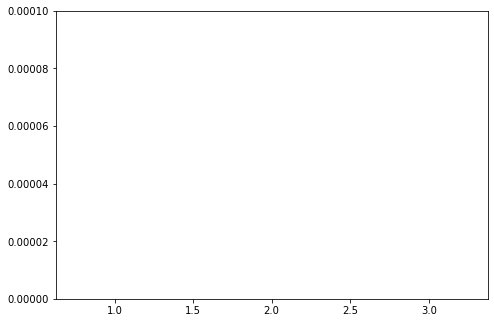

In [13]:
import matplotlib.pyplot as plt

# Create a figure instance
fig = plt.figure()

# Create an axes instance
ax = fig.add_axes([0,0,1,1])

# Create the boxplot
bp = ax.violinplot([effective_sample_sizes, [1e-2], [2e-2]])
plt.ylim(0,1e-4)
plt.show()

  0%|          | 0/2500 [00:00<?, ?it/s]

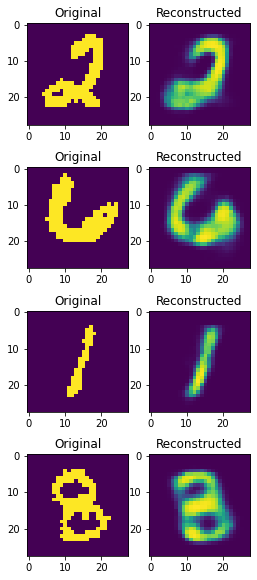

In [14]:
#test_results = train_and_evaluate(model, [optim], train_loader, test_loader, eval_discard(IWAE_loss, M=1, K=64), 6, 10, model_dir+"test")
 
#model.load_state_dict(torch.load(model_dir+'20220404-192054MIWAE8_8_run1_model_epoch6_'))


import matplotlib.pyplot as plt

plt.figure(figsize=(4,26))

for imgs, _ in tqdm(test_loader):
    for i in range(imgs.shape[0]):
        if i >= 10:
            break
        img = imgs[i].view(28 * 28).to(device)
        recon = model.reconstruct(img)
        ax = plt.subplot(10, 2, 2 * i + 1)
        ax.imshow(img.view(28, 28).clone().detach().cpu())
        plt.title("Original")
        ax = plt.subplot(10, 2, 2 * i + 2)
        ax.imshow(recon.view(28, 28).clone().detach().cpu())
        plt.title("Reconstructed")
    break
plt.show()

In [17]:
mnist_train_data.load_all_results()

{'vae': [(1,
      Unnamed: 0  epoch    iwae-64      logpx       -kl
   0           0      1 -35.315975 -35.314663  0.001312
   1           1      2 -31.231741 -31.231688  0.000053)],
 'iwae': [(1,
      Unnamed: 0  epoch    iwae-64      logpx       -kl
   0           0      1 -38.933610 -38.945226 -0.011616
   1           1      2 -34.351565 -34.347382  0.004183)],
 'ciwae-05': [(1,
      Unnamed: 0  epoch    iwae-64      logpx       -kl
   0           0      1 -35.040693 -35.041270 -0.000577
   1           1      2 -31.065533 -31.064138  0.001394)],
 'miwae-8-8': [(1,
      Unnamed: 0  epoch    iwae-64      logpx       -kl
   0           0      1 -35.414847 -35.417075 -0.002228
   1           1      2 -31.516740 -31.520922 -0.004182)],
 'piwae-8-8': [(1,
      Unnamed: 0  epoch    iwae-64      logpx       -kl
   0           0      1 -36.546453 -36.553201 -0.006748
   1           1      2 -32.165061 -32.167095 -0.002034)]}

In [18]:
def plot_metric(ress: dict, col: str, ax):
    lines = []
    for loss in ress.keys():
        table = ress[loss][0][1]
        epochs = table['epoch']
        metric = table[col]
        line, = ax.plot(epochs, metric, label=loss)
        lines.append(line)
    ax.legend(handles=lines)

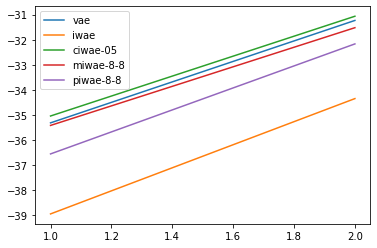

In [19]:
fig, ax = plt.subplots()
plot_metric(mnist_train_data.load_all_results(), 'logpx', ax)